In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# add the subregion as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"subregion"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["subregion","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["subregion","geometry"]])

In [5]:
# rgi_gdf.head()

In [6]:
# for each row, use that glacier's geometry to clip the data and save it as a mask
# but subset by region first, so we avoid constantly opening and closing the regional files
all_regions = np.sort(np.unique(rgi_gdf['subregion'].values))

c=0
for r in all_regions:
    print("Starting region", r)
    
    # define path the the product we will open and clip
    path_open = os.path.join(folder_HMA, "Datasets", "GEE outputs", "usable counts",
                             f"usable_count_r{str(r).zfill(2)}.tif")
    
    # open with riox
    xr_full = riox.open_rasterio(path_open, masked=False)
    
    # collapse to single band
    xr_full = xr_full.max('band').astype('float')#.drop_vars('band')

    # subset to the rgi in this region
    gdf_susbet = rgi_gdf[rgi_gdf['subregion']==r]
    
    for idx, row in gdf_susbet.iterrows():
        c+=1
        # if c>1: continue

        # grab glacier geometry, region, rgiid
        rgi_id = row['rgi_id']
        region = row['subregion']
        geom = row['geometry']

        # print progress
        if c%10==0: print(r, c, "of", len(rgi_gdf), rgi_id)

        # clip the big xr to the rgi geometry
        xr_clipped = xr_full.rio.clip([geom], all_touched=True)

        # simplify to 0s and 1s
        xr_mask = xr.where(xr_clipped>0, 1, 0).astype('uint8')

        # quickly count the number of pixels
        # n_pix = np.sum(xr_mask).values
        # if n_pix<100: print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", rgi_id)
        
        # save as geotiff
        out_path = os.path.join(folder_glaciers, rgi_id, 'glacier_mask.tif')
        xr_mask.rio.to_raster(out_path, compress='LZW', tiled=True, dtype="uint8")

print("All done!")

Starting region 1
Starting region 2
2 10 of 769 RGI2000-v7.0-G-15-17006
Starting region 3
3 20 of 769 RGI2000-v7.0-G-15-14828
Starting region 4
4 30 of 769 RGI2000-v7.0-G-13-69268
4 40 of 769 RGI2000-v7.0-G-13-71532
4 50 of 769 RGI2000-v7.0-G-13-71720
4 60 of 769 RGI2000-v7.0-G-13-73319
4 70 of 769 RGI2000-v7.0-G-15-11613
Starting region 5
5 80 of 769 RGI2000-v7.0-G-15-11027
Starting region 6
6 90 of 769 RGI2000-v7.0-G-15-09295
6 100 of 769 RGI2000-v7.0-G-15-09537
6 110 of 769 RGI2000-v7.0-G-15-10171
Starting region 7
7 120 of 769 RGI2000-v7.0-G-15-06654
7 130 of 769 RGI2000-v7.0-G-15-06827
7 140 of 769 RGI2000-v7.0-G-15-07190
7 150 of 769 RGI2000-v7.0-G-15-07878
7 160 of 769 RGI2000-v7.0-G-15-08080
7 170 of 769 RGI2000-v7.0-G-15-08356
7 180 of 769 RGI2000-v7.0-G-15-08688
Starting region 8
8 190 of 769 RGI2000-v7.0-G-15-04301
8 200 of 769 RGI2000-v7.0-G-15-04937
8 210 of 769 RGI2000-v7.0-G-15-05068
8 220 of 769 RGI2000-v7.0-G-15-05330
8 230 of 769 RGI2000-v7.0-G-15-05619
8 240 of 769 R

In [7]:
# do this again, but create mask for debris-covered area
# we want to have the extent be the same at the full rgi extent

c=0
# iterate through each glacier
for idx, row in dc_gdf.iterrows():
    c+=1
    # if c>1: break
    
    # grab glacier geometry, region, rgiid
    rgi_id = row['rgi_id']
    region = row['subregion']
    geom = row['geometry']
    
    # print progress
    if c%10==0: print(c, "of", len(dc_gdf), rgi_id)
    
    # define path the og glacier mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'glacier_mask.tif')

    # open with riox
    xr_full = riox.open_rasterio(path_open, masked=False).max('band').astype('float')

    # clip the og mask to the debris-cover geom
    xr_clipped = xr_full.rio.clip([geom], all_touched=True, drop=False)

    # simplify to 0s and 1s
    xr_mask = xr.where(xr_clipped>0, 1, 0).astype('uint8')
   
    # make sure we don't allow anything that isn't on-glacier to be classified as debris
    # xr_mask = xr.where(xr_full>0, xr_mask, 0).astype('uint8')
    xr_mask = xr_mask*xr_full
    
    # quickly count the number of pixels
    n_pix = np.sum(xr_mask).values
    if n_pix<100: print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", rgi_id)

    # save as geotiff
    out_path = os.path.join(folder_glaciers, rgi_id, 'debris_mask.tif')
    xr_mask.rio.to_raster(out_path, compress='LZW', tiled=True, dtype="uint8")

print("All done!")

10 of 769 RGI2000-v7.0-G-13-71707
20 of 769 RGI2000-v7.0-G-13-73081
30 of 769 RGI2000-v7.0-G-13-70791
40 of 769 RGI2000-v7.0-G-15-11615
50 of 769 RGI2000-v7.0-G-14-29468
60 of 769 RGI2000-v7.0-G-14-29777
70 of 769 RGI2000-v7.0-G-14-30347
80 of 769 RGI2000-v7.0-G-14-26878
90 of 769 RGI2000-v7.0-G-14-26889
100 of 769 RGI2000-v7.0-G-14-26871
110 of 769 RGI2000-v7.0-G-14-29919
120 of 769 RGI2000-v7.0-G-14-33059
130 of 769 RGI2000-v7.0-G-14-35510
140 of 769 RGI2000-v7.0-G-14-31106
150 of 769 RGI2000-v7.0-G-14-31261
160 of 769 RGI2000-v7.0-G-15-01541
170 of 769 RGI2000-v7.0-G-15-01184
180 of 769 RGI2000-v7.0-G-15-01607
190 of 769 RGI2000-v7.0-G-15-00882
200 of 769 RGI2000-v7.0-G-15-00521
210 of 769 RGI2000-v7.0-G-15-00711
220 of 769 RGI2000-v7.0-G-15-01899
230 of 769 RGI2000-v7.0-G-15-02542
240 of 769 RGI2000-v7.0-G-15-02450
250 of 769 RGI2000-v7.0-G-15-03047
260 of 769 RGI2000-v7.0-G-15-04937
270 of 769 RGI2000-v7.0-G-15-04966
280 of 769 RGI2000-v7.0-G-15-05253
290 of 769 RGI2000-v7.0-G-15-

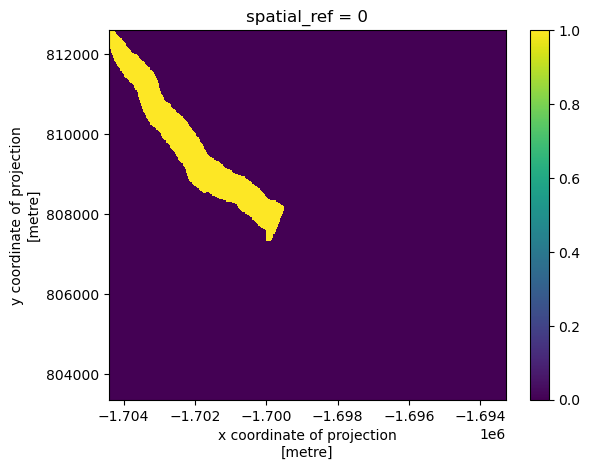

In [8]:
xr_mask.plot()

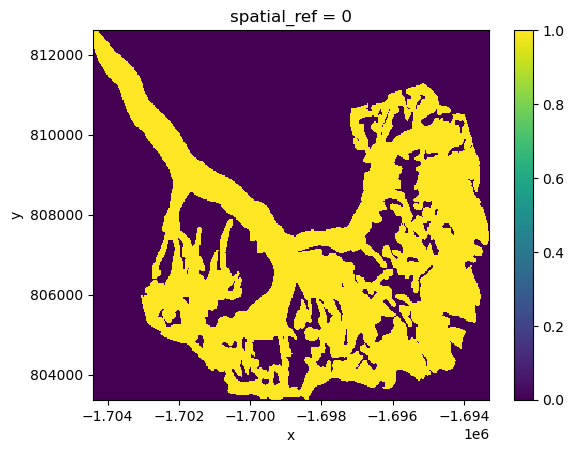

In [9]:
xr_full.plot()

In [10]:
xr_full

<xarray.DataArray (y: 308, x: 371)>
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 -1.704e+06 -1.704e+06 ... -1.693e+06 -1.693e+06
  * y            (y) float64 8.126e+05 8.126e+05 ... 8.034e+05 8.034e+05
    spatial_ref  int32 0